# Synthetic Kidney Disease Data Analysis

## Project Overview
This project focuses on simulating the real-time collection, processing, and analysis of kidney disease data using synthetic datasets. The primary goal is to develop a scalable data pipeline capable of handling sensor data, applying noise reduction techniques, and training a model to predict kidney disease.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve,precision_score, recall_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import PartialDependenceDisplay
import scipy
import statsmodels.api as sm
import ssl
import urllib.request
from ucimlrepo import fetch_ucirepo

## **1) Pulling and Understanding the Data**

### Goal:
Load and explore the Chronic Kidney Disease dataset to understand its structure, features, and distributions before generating synthetic data.

### Loading the Data
First, we will load the CKD dataset from the UCI repository.

In [2]:
# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

# Fetch the Chronic Kidney Disease dataset
chronic_kidney_disease = fetch_ucirepo(id=336)

# Extract features (X) and target (y) as pandas DataFrames
X = pd.DataFrame(chronic_kidney_disease.data.features)
y = pd.Series(chronic_kidney_disease.data.targets.iloc[:, 0], name='class')

# Combine the features and target into one DataFrame
ckd_data = pd.concat([X, y], axis=1)

# Display the first few rows to confirm
print("Data Head:\n", ckd_data.head())
print("--------------------------------------------------------------------------------------")
# Print metadata and variable information
print("\nDataset Metadata:\n", chronic_kidney_disease.metadata)
print("-------------------------------------------------------------------------------------------------------------------------------------------")
print("\nVariable Information:\n", chronic_kidney_disease.variables)

Data Head:
     age    bp     sg   al   su     rbc        pc         pcc          ba  \
0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

     bgr  ...   pcv    wbcc  rbcc  htn   dm  cad  appet   pe  ane class  
0  121.0  ...  44.0  7800.0   5.2  yes  yes   no   good   no   no   ckd  
1    NaN  ...  38.0  6000.0   NaN   no   no   no   good   no   no   ckd  
2  423.0  ...  31.0  7500.0   NaN   no  yes   no   poor   no  yes   ckd  
3  117.0  ...  32.0  6700.0   3.9  yes   no   no   poor  yes  yes   ckd  
4  106.0  ...  35.0  7300.0   4.6   no   no   no   good   no   no   ckd  

[5 rows x 25 columns]
----------------------------------------------------------------

## **2) Exploratory Data Analysis (EDA)**

Understand, process, clean the data to prepare it for analysis.<br>
 - ##### **Handle missing values**
 - ##### **Normalize features**
 - ##### **Implement noise reduction techniques**

In [3]:
# Summary statistics of the data
summary_stats = ckd_data.describe()

# Display missing values and summary statisticsprint("Missing Values per Column:\n", missing_values)
print("Summary Statistics:\n\n", summary_stats)


Summary Statistics:

               age          bp          sg          al          su         bgr  \
count  391.000000  388.000000  353.000000  354.000000  351.000000  356.000000   
mean    51.483376   76.469072    1.017408    1.016949    0.450142  148.036517   
std     17.169714   13.683637    0.005717    1.352679    1.099191   79.281714   
min      2.000000   50.000000    1.005000    0.000000    0.000000   22.000000   
25%     42.000000   70.000000    1.010000    0.000000    0.000000   99.000000   
50%     55.000000   80.000000    1.020000    0.000000    0.000000  121.000000   
75%     64.500000   80.000000    1.020000    2.000000    0.000000  163.000000   
max     90.000000  180.000000    1.025000    5.000000    5.000000  490.000000   

               bu          sc         sod         pot        hemo         pcv  \
count  381.000000  383.000000  313.000000  312.000000  348.000000  329.000000   
mean    57.425722    3.072454  137.528754    4.627244   12.526437   38.884498   
std  

In [4]:
# Check for missing values
missing_values = ckd_data.isnull().sum()
print("Missing Values per Column:\n", missing_values)


Missing Values per Column:
 age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64


### 2.1) Handle Missing Values
Start by filling in or addressing any missing values in the dataset.

**a. Numeric Features:** 
- Impute missing values using the median, as it is less sensitive to outliers

**b. Categorical Features:**
- Impute missing values in categorical features using the mode (most frequent value).

In [5]:
# Running this shows there are 3 values of the target variable class 
# that states whether a patient has Chronic Kidney Disease or not, and it should only be 2
print(ckd_data['class'].value_counts())

class
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64


In [6]:
# Correct the irregular class label
ckd_data['class'] = ckd_data['class'].replace({'ckd\t': 'ckd'})

# Now, check the unique values to confirm the correction
print(ckd_data['class'].value_counts())

class
ckd       250
notckd    150
Name: count, dtype: int64


In [7]:
categorical_features = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

# Impute missing values for categorical features with the mode
for feature in categorical_features:
    ckd_data[feature] = ckd_data[feature].fillna(ckd_data[feature].mode()[0])


In [8]:
# List of numeric features to impute
numeric_features = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']

# Impute missing values for the numeric features with the median
ckd_data[numeric_features] = ckd_data[numeric_features].fillna(ckd_data[numeric_features].median())


In [9]:
# Verify that there are no more missing values
missing_values_after = ckd_data.isnull().sum()
print("Missing Values after Imputation:\n", missing_values_after)


Missing Values after Imputation:
 age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64


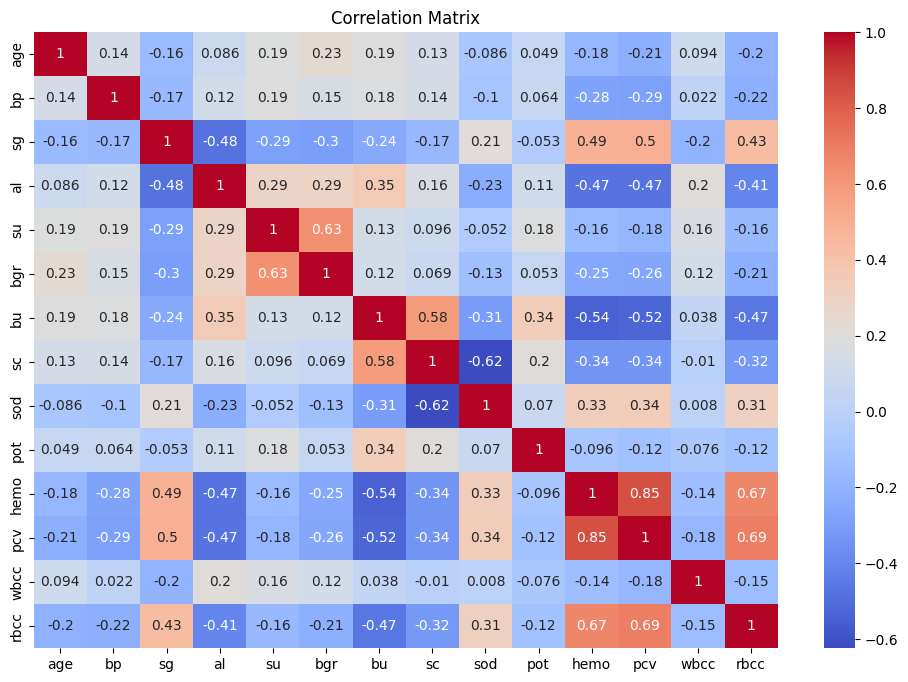

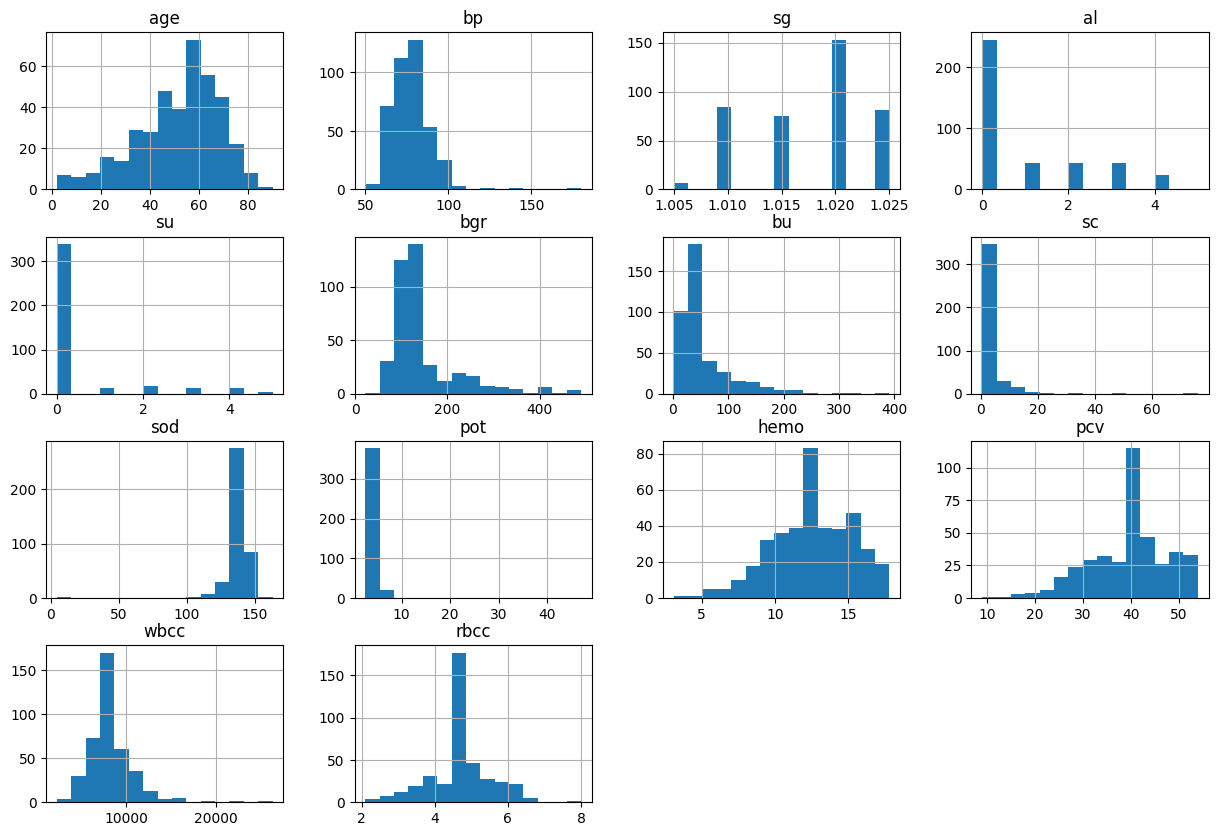

In [10]:
# Filter out only numeric columns
numeric_data = ckd_data.select_dtypes(include=[float, int])

# Calculate and plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Histograms for numeric features
ckd_data[numeric_features].hist(bins=15, figsize=(15, 10))
plt.show()

#### Distribution Plots:
**Age:** 
- The distribution is relatively normal with a peak around 50-60 years. This suggests that age is fairly distributed among the patients, with a possible skew towards older individuals, which is expected in kidney disease datasets.<br>

**Blood Pressure (bp):** 
- Most values cluster around 70-100 mmHg, with some higher values. This distribution seems typical, though it may be useful to investigate any extreme outliers.<br>

**Specific Gravity (sg):** 
- The values are discrete, centered around specific values (1.010, 1.015, 1.020), which is expected as it’s a measurement with specific ranges.<br>

**Albumin (al), Sugar (su):** 
- Both features have distributions heavily skewed towards 0, indicating that many patients have no albumin or sugar detected in their urine, which is normal.<br>

**Blood Glucose Random (bgr):**
- This is skewed to the right with a long tail, which indicates that while most patients have normal blood glucose levels, some have significantly higher levels, likely related to diabetes.<br>

**Serum Creatinine (sc), Blood Urea (bu):** 
- These show a right skew with a long tail, indicating that while most patients have normal kidney function markers, some have significantly impaired kidney function.<br>

**Hemoglobin (hemo), Packed Cell Volume (pcv):** 
- These distributions show variations but are centered around expected values, with some spread likely due to the varying stages of kidney disease among patients.<br>

**Red Blood Cell Count (rbcc), White Blood Cell Count (wbcc):** 
- Both show a fairly normal distribution, though with some variability that might reflect different disease stages or conditions.<br>

#### Correlation Matrix:
##### *High Positive Correlations:*
**Hemoglobin (hemo) and Packed Cell Volume (pcv):** 
- Strong positive correlation (0.85), which makes sense because both measure aspects of the blood’s ability to carry oxygen.<br>

**Serum Creatinine (sc) and Blood Urea (bu):** 
- Positive correlation (0.58), reflecting that both are waste products filtered by the kidneys, with elevated levels indicating impaired kidney function.<br>

**Hemoglobin (hemo) and Red Blood Cell Count (rbcc):** 
- Positive correlation (0.67), consistent with both being related to blood health.<br>

##### *High Negative Correlations:*
**Packed Cell Volume (pcv) and Serum Creatinine (sc):** 
- Negative correlation (-0.52), which could suggest that higher creatinine levels (indicating worse kidney function) are associated with lower packed cell volumes, possibly due to anemia.<br>

**Albumin (al) and Specific Gravity (sg):**
- Negative correlation (-0.48), possibly indicating that as kidney damage worsens (higher albumin), the kidney's ability to concentrate urine decreases.

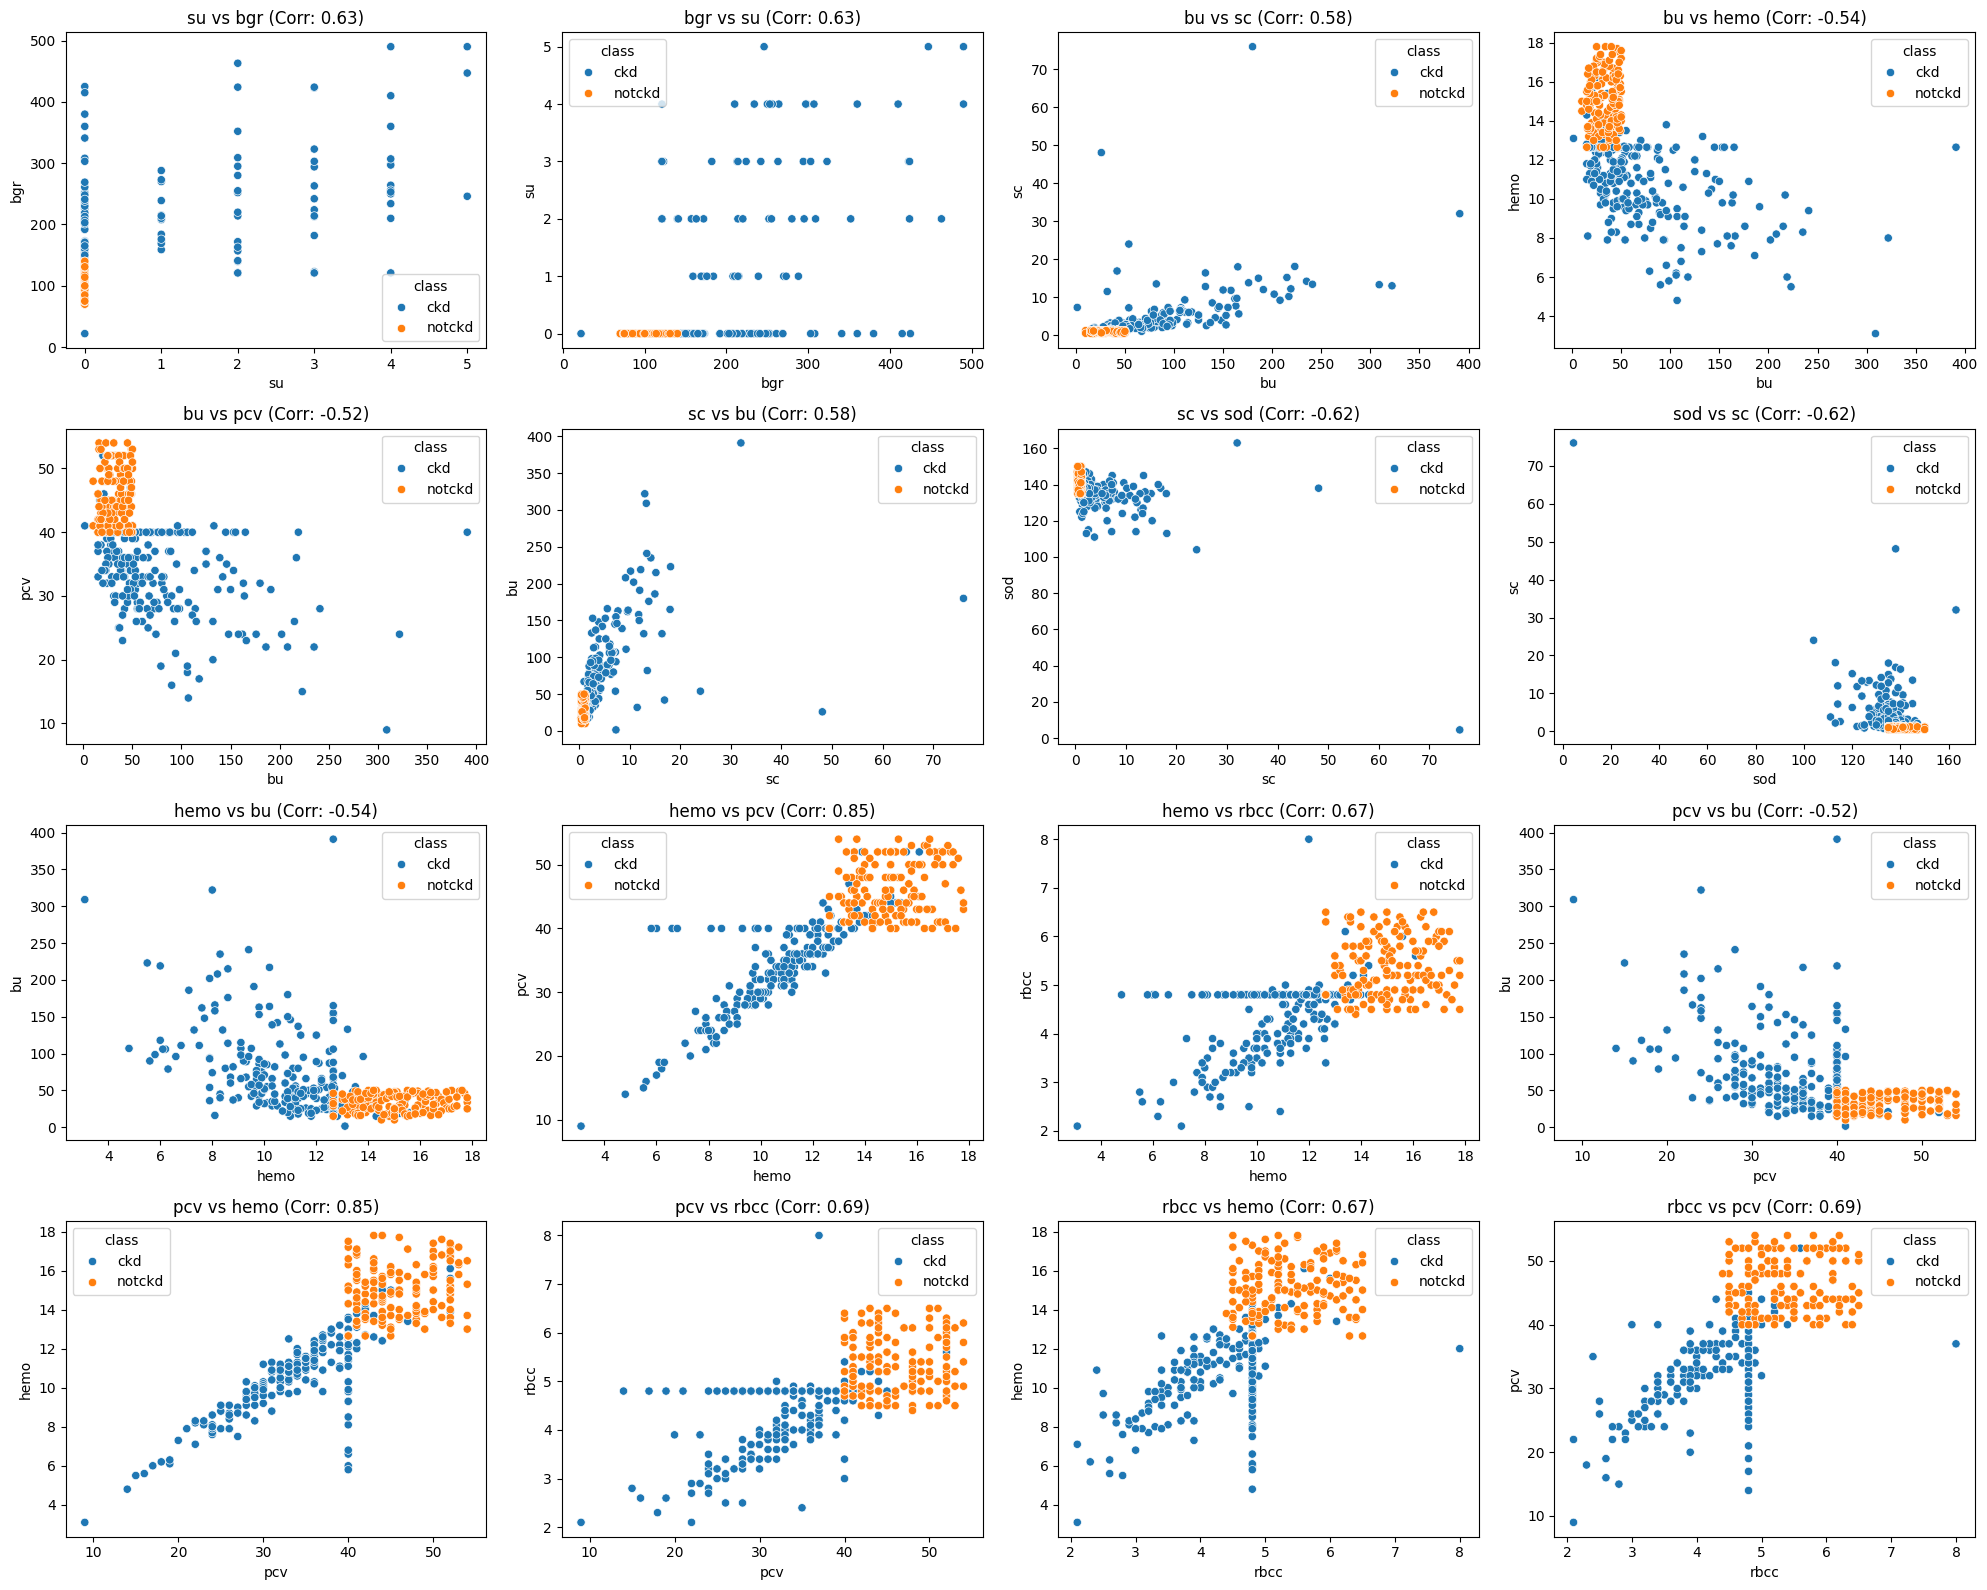

In [11]:
# 1. Filter out only numeric columns
numeric_data = ckd_data.select_dtypes(include=[float, int])

# 2. Identify high correlation pairs
threshold = 0.5 # Absolute Value of Correlation must be over this number
high_corr_pairs = numeric_data.corr().unstack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[(high_corr_pairs['Feature1'] != high_corr_pairs['Feature2']) & (high_corr_pairs['Correlation'].abs() > threshold)]

# Assuming high_corr_pairs is already defined
num_pairs = len(high_corr_pairs)
cols = 4
# Increase the number of columns to fit more plots horizontally
rows = int(np.ceil(num_pairs / cols))  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing
# Plot each pair in a subplot
for i, (index, row) in enumerate(high_corr_pairs.iterrows()):
    sns.scatterplot(data=ckd_data, x=row['Feature1'], y=row['Feature2'], hue='class', ax=axes[i])
    axes[i].set_title(f"{row['Feature1']} vs {row['Feature2']} (Corr: {row['Correlation']:.2f})")

# Remove any empty subplots (in case there are more subplots than pairs)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



#### General Observations:

***Class Separation:***
- The orange and blue dots represent the two main classes (ckd and notckd). The scatterplots show how these classes are distributed across pairs of features. In some plots, the classes are well-separated, indicating that these feature pairs are good discriminators for the classification task.<br>

***Specific Pair Plot Analysis:*** <br>

**su vs bgr (Corr: 0.63):**
- The plot shows some separation between ckd and notckd, suggesting that higher sugar levels and blood glucose might be indicative of kidney disease.<br>

**bu vs sc (Corr: 0.58):**
- The plot shows that as bu and sc increase, the likelihood of belonging to the ckd class increases.<br>

**hemo vs bu (Corr: -0.54):**
- Patients with lower hemoglobin and higher blood urea are more likely to be classified as ckd.<br>

**pcv vs hemo (Corr: 0.85):**
- The ckd class tends to have lower pcv and hemo values, which is consistent with the fact that chronic kidney disease often leads to anemia.<br>

**rbcc vs hemo (Corr: 0.67):**
- The separation between ckd and notckd is visible, with ckd generally having lower values for both features.<br>

## **3) Feature Engineering**
Apply any necessary transformations to features to better prepare them for modeling. This includes scaling, normalization, encoding categorical variables as well as dropping/creating new features that better represent the patterns in the data.

#### **Encoding Categorical Variables**
We'll encode the categorical variables into numerical values that models can use. This typically involves converting categories into dummy/indicator variables.<br>

#### **Scaling/Normalization**
We'll ensure all numeric features are on a similar scale. This is especially important for models like Logistic Regression or SVM, which are sensitive to feature scaling.<br>

#### **Creating Interaction Terms**
We can create new features based on interactions between existing ones, especially for the ones with a suspected combined effect on the outcome.<br>

### 3.1) Encoding Categorical Variables

Let's start by encoding the categorical variables. We'll use pd.get_dummies() to convert the categorical features into dummy variables.

In [12]:
# Categorical features in the dataset
categorical_features = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

# Encoding the categorical variables
ckd_encoded = pd.get_dummies(ckd_data, columns=categorical_features, drop_first=True)

# Display the first few rows of the encoded dataset
ckd_encoded.head()


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc_normal,pcc_present,ba_present,htn_yes,dm_no,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,138.0,4.4,...,True,False,False,True,False,True,False,False,False,False
1,7.0,50.0,1.020,4.0,0.0,121.0,18.0,0.8,138.0,4.4,...,True,False,False,False,True,False,False,False,False,False
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,138.0,4.4,...,True,False,False,False,False,True,False,True,False,True
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,False,True,False,True,True,False,False,True,True,True
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,138.0,4.4,...,True,False,False,False,True,False,False,False,False,False


**Output**
- Binary columns like pc_normal, pcc_present, etc., are created for categorical features.
- The original numeric features (e.g., age, bp, sg, etc.) are retained.
- The binary values (True/False) can be directly used for modeling after converting them into integers (1 for True and 0 for False),

### 3.2) Scaling/Normalization

We’ll standardize the numeric features so that they all have a mean of 0 and a standard deviation of 1.

In [13]:
# Features to scale
features_to_scale = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']

# Scaling the features
scaler = StandardScaler()
ckd_encoded[features_to_scale] = scaler.fit_transform(ckd_encoded[features_to_scale])

# Display the first few rows to confirm scaling
ckd_encoded.head()


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc_normal,pcc_present,ba_present,htn_yes,dm_no,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,-0.210031,0.254214,0.421486,0.076249,-0.380269,-0.320122,-0.419451,-0.319668,0.040104,-0.062903,...,True,False,False,True,False,True,False,False,False,False
1,-2.627234,-1.972476,0.421486,2.363728,-0.380269,-0.320122,-0.784315,-0.390819,0.040104,-0.062903,...,True,False,False,False,True,False,False,False,False,False
2,0.615355,0.254214,-1.421074,0.838742,2.507853,3.697618,-0.074858,-0.212942,0.040104,-0.062903,...,True,False,False,False,False,True,False,True,False,True
3,-0.210031,-0.488016,-2.342354,2.363728,-0.380269,-0.373337,-0.014047,0.142813,-2.896333,-0.737181,...,False,True,False,True,True,False,False,True,True,True
4,-0.033163,0.254214,-1.421074,0.838742,-0.380269,-0.519679,-0.622154,-0.284093,0.040104,-0.062903,...,True,False,False,False,True,False,False,False,False,False


In [14]:
# Summary statistics of the data
summary_stats_2 = ckd_encoded.describe()

# Display missing values and summary statisticsprint("Missing Values per Column:\n", missing_values)
print("Summary Statistics:\n\n", summary_stats_2)

Summary Statistics:

               age            bp            sg            al            su  \
count  400.000000  4.000000e+02  4.000000e+02  4.000000e+02  4.000000e+02   
mean     0.000000 -2.309264e-16  3.183231e-14  3.552714e-17 -7.105427e-17   
std      1.001252  1.001252e+00  1.001252e+00  1.001252e+00  1.001252e+00   
min     -2.922015 -1.972476e+00 -2.342354e+00 -6.862436e-01 -3.802694e-01   
25%     -0.563768 -4.880162e-01 -4.997944e-01 -6.862436e-01 -3.802694e-01   
50%      0.202662  2.542138e-01  4.214856e-01 -6.862436e-01 -3.802694e-01   
75%      0.733267  2.542138e-01  4.214856e-01  8.387421e-01 -3.802694e-01   
max      2.266128  7.676514e+00  1.342766e+00  3.126221e+00  4.433268e+00   

              bgr            bu            sc           sod           pot  \
count  400.000000  4.000000e+02  4.000000e+02  4.000000e+02  4.000000e+02   
mean     0.000000 -1.065814e-16  7.105427e-17  6.039613e-16 -5.329071e-17   
std      1.001252  1.001252e+00  1.001252e+00  1.0012

The mean of each numeric column is very close to zero, and the standard deviation (std) is close to one, which indicates that the features have been successfully standardized.

### 3.3) Creating Interaction Terms

Using the correlation matrix that was graphed before standardization we will identify potential interactions between features. This step can be performed after the initial model performance as well.

Based on the correlation matrix and domain knowledge, the following interaction terms are strong candidates:

**bp_x_sc:** 
  - Interaction between blood pressure and serum creatinine.
  - Rationale: Blood pressure affects kidney filtration, and elevated serum creatinine indicates reduced kidney function.
  - [reference](https://www.niddk.nih.gov/health-information/kidney-disease/high-blood-pressure)

**bu_x_sc:**
  - Interaction between blood urea and serum creatinine.
  - Rationale:  If BUN numbers are higher than your baseline, and if your creatinine is also high, then kidney failure is likely.
  - [reference](https://my.clevelandclinic.org/health/diagnostics/17684-blood-urea-nitrogen-bun-test)

**hemo_x_pcv:**
  - Interaction between hemoglobin and packed cell volume.
  - Rationale: Both are related to blood health, and their interaction could highlight the degree of anemia related to kidney disease.
  - [reference](https://journals.lww.com/jaht/fulltext/2019/10020/the_spectrum_of_red_blood_cell_parameters_in.4.aspx)

In [15]:
# Creating interaction terms based on strong correlations
ckd_encoded['bp_x_sc'] = ckd_encoded['bp'] * ckd_encoded['sc']
ckd_encoded['bu_x_sc'] = ckd_encoded['bu'] * ckd_encoded['sc']
ckd_encoded['hemo_x_pcv'] = ckd_encoded['hemo'] * ckd_encoded['pcv']

# Display the first few rows to confirm interaction terms
ckd_encoded.head()


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,htn_yes,dm_no,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes,bp_x_sc,bu_x_sc,hemo_x_pcv
0,-0.210031,0.254214,0.421486,0.076249,-0.380269,-0.320122,-0.419451,-0.319668,0.040104,-0.062903,...,True,False,True,False,False,False,False,-0.081264,0.134085,0.635331
1,-2.627234,-1.972476,0.421486,2.363728,-0.380269,-0.320122,-0.784315,-0.390819,0.040104,-0.062903,...,False,True,False,False,False,False,False,0.770882,0.306525,0.060813
2,0.615355,0.254214,-1.421074,0.838742,2.507853,3.697618,-0.074858,-0.212942,0.040104,-0.062903,...,False,False,True,False,True,False,True,-0.054133,0.015940,1.075305
3,-0.210031,-0.488016,-2.342354,2.363728,-0.380269,-0.373337,-0.014047,0.142813,-2.896333,-0.737181,...,True,True,False,False,True,True,True,-0.069695,-0.002006,0.429903
4,-0.033163,0.254214,-1.421074,0.838742,-0.380269,-0.519679,-0.622154,-0.284093,0.040104,-0.062903,...,False,True,False,False,False,False,False,-0.072220,0.176749,0.173971


## **4) Modeling**
#### **Train-Test Split:** 
 - Split dataset into training and testing sets to evaluate the model's performance on unseen data.<br>
 
#### **Model Selection:**
 - We will start with simpler models like Logistic Regression and Decision Trees before moving to more complex models like Random Forests, XGBoost, or Neural Networks.<br>
 
#### **Model Training:**
- Train the models and evaluate their initial performance.<br>

### **4.1) Logistic Regression**

In [16]:
# Define the features (X) and the target variable (y)
X = ckd_encoded.drop('class', axis=1)  # Features (excluding the target variable)
y = ckd_encoded['class']  # Target variable

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shapes of the resulting datasets
print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training data shape: X_train: (320, 28), y_train: (320,)
Testing data shape: X_test: (80, 28), y_test: (80,)


Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

         ckd       1.00      0.98      0.99        50
      notckd       0.97      1.00      0.98        30

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80


Confusion Matrix:
[[49  1]
 [ 0 30]]

ROC-AUC Score: 1.00


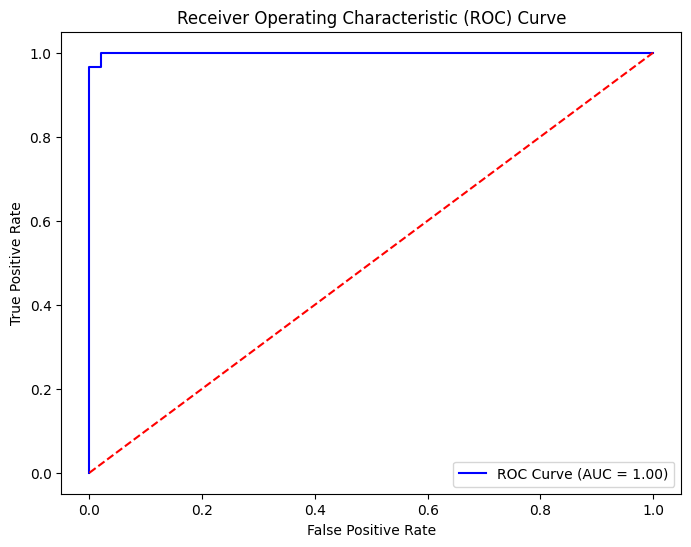

In [17]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Encode the target labels into binary values
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)

# ROC-AUC score
y_prob = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
roc_auc = roc_auc_score(y_test_encoded, y_prob)
print(f"\nROC-AUC Score: {roc_auc:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


- The model has performed very well with an accuracy of 99%, a ROC-AUC score of 1.00, and a strong classification report. The confusion matrix indicates that the model correctly classified almost all instances, with just one instance misclassified. 

- These results could potentially indicate that the model is overfitting, especially given the near-perfect accuracy and AUC score.

-  To check we will perform k-fold cross-validation to see if the model maintains its performance across different subsets of the data. If the performance drops significantly on the validation folds, it suggests overfitting.

In [18]:
# Number of folds
k = 5

# Stratified K-Folds cross-validator ensures that each fold is representative of the class distribution
skf = StratifiedKFold(n_splits=k)

# List to hold accuracy and ROC-AUC scores for each fold
accuracy_scores = []
roc_auc_scores = []

for train_index, test_index in skf.split(X, y):
    # Split data into train and test sets
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train_fold, y_train_fold)
    
    # Predict on the test fold
    y_pred_fold = model.predict(X_test_fold)
    y_prob_fold = model.predict_proba(X_test_fold)[:, 1]
    
    # Calculate accuracy and ROC-AUC
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    roc_auc_fold = roc_auc_score(y_test_fold, y_prob_fold)
    
    # Store the results
    accuracy_scores.append(accuracy_fold)
    roc_auc_scores.append(roc_auc_fold)

# Calculate the mean and standard deviation of accuracy and ROC-AUC scores
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
mean_roc_auc = np.mean(roc_auc_scores)
std_roc_auc = np.std(roc_auc_scores)

# Output the results
print(f"K-Fold Cross-Validation Results ({k} folds):")
print(f"Mean Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}")
print(f"Mean ROC-AUC: {mean_roc_auc:.2f} ± {std_roc_auc:.2f}")


K-Fold Cross-Validation Results (5 folds):
Mean Accuracy: 0.99 ± 0.01
Mean ROC-AUC: 1.00 ± 0.00


#### **Interpretation:**

 - Mean Accuracy: The model maintains a high accuracy across all folds, with minimal variance, suggesting that the model is consistently performing well on different subsets of the data.
 - Mean ROC-AUC: A perfect ROC-AUC score of 1.00 across all folds further confirms that the model is distinguishing between the classes effectively.<br>
 
#### **Conclusion:**
 - These results indicate that the model is generalizing well and is not overfitting to the training data.
 - The small standard deviation in accuracy and the consistent ROC-AUC score across all folds imply that the model's performance is stable and reliable.



#### **Further Evaluation:** 
- Although the model shows strong performance, lets explore other metrics (like precision, recall, and F1-score) in more detail for each fold to ensure balanced performance across all aspects of the classification.

In [19]:
# Define the scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label='ckd'),
    'recall': make_scorer(recall_score, pos_label='ckd'),
    'f1': make_scorer(f1_score, pos_label='ckd'),
    'roc_auc': 'roc_auc'
}

# Perform K-Fold Cross-Validation with 5 folds
cv_results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False)

# Display the results
print(f"K-Fold Cross-Validation Results ({k} folds):")
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.2f} ± {cv_results['test_accuracy'].std():.2f}")
print(f"Mean Precision: {cv_results['test_precision'].mean():.2f} ± {cv_results['test_precision'].std():.2f}")
print(f"Mean Recall: {cv_results['test_recall'].mean():.2f} ± {cv_results['test_recall'].std():.2f}")
print(f"Mean F1-Score: {cv_results['test_f1'].mean():.2f} ± {cv_results['test_f1'].std():.2f}")
print(f"Mean ROC-AUC: {cv_results['test_roc_auc'].mean():.2f} ± {cv_results['test_roc_auc'].std():.2f}")


K-Fold Cross-Validation Results (5 folds):
Mean Accuracy: 0.99 ± 0.01
Mean Precision: 0.99 ± 0.02
Mean Recall: 1.00 ± 0.01
Mean F1-Score: 0.99 ± 0.01
Mean ROC-AUC: 1.00 ± 0.00


##### **Observations**

- Given the results achieved with K-fold cross-validation and the model performed consistently well across all folds with minimal variation in accuracy, precision, recall, F1-score, and ROC-AUC, the model seems to be performing well and is likely not overfitted.

- The next step would be deployment.

##### **Deployment**

- For presenting a well-performing model, it's crucial to include visualizations that effectively communicate the model's performance, key insights, and areas of focus. Below are some essential visualizations:

#### **4.1.1) Confusion Matrix:**
**Purpose:** 
  - To show the actual vs. predicted classifications.
    
**Why It's Important:**
  - It provides a straightforward way to understand how well the model is distinguishing between classes (e.g., CKD vs. non-CKD).

**Output:**
  - The confusion matrix shows that the model performed well, with only one misclassification.

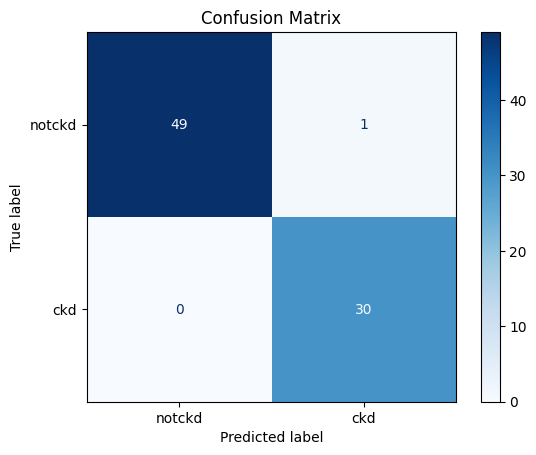

In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['notckd', 'ckd'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


#### **4.1.2) ROC Curve:**
**Purpose:** 
  - To illustrate the model's ability to distinguish between classes at various threshold levels.
    
**Why It's Important:**
  - The ROC curve, along with the AUC (Area Under Curve), is a great way to visualize the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity).

**Output:**
  - The AUC (Area Under the Curve) of 1.0 suggests that your model is excellent at distinguishing between the two classes.

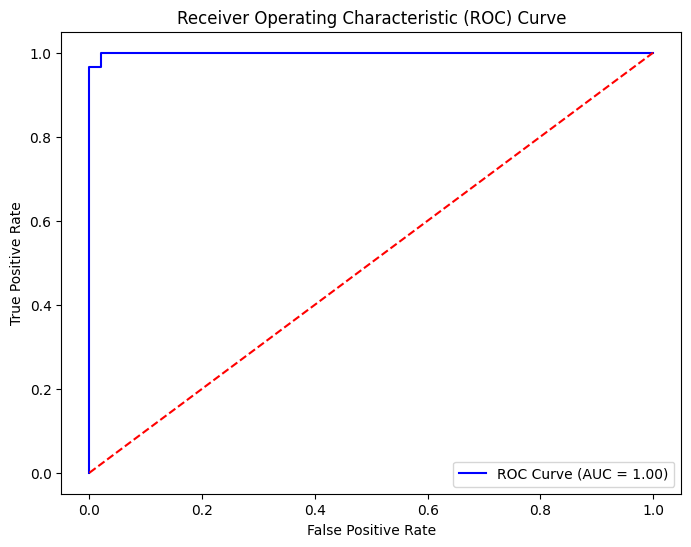

In [22]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#### **4.1.3) Precision-Recall Curve:**
**Purpose:** 
  - To evaluate the trade-off between precision and recall for different threshold settings.
    
**Why It's Important:**
  - Useful in imbalanced datasets where one class is more frequent than the other.

**Output:**
  - The curve suggests high precision and recall, indicating that the model performs well even at different thresholds


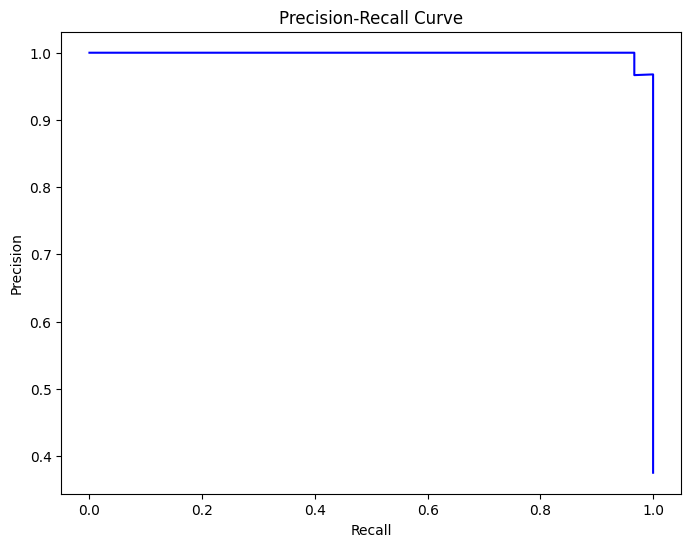

In [23]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Convert 'ckd' to 1 and 'notckd' to 0
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test).ravel()

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


#### **4.1.4) Feature Importance:**
**Purpose:** 
  - To rank the features based on their importance in the model.
    
**Why It's Important:**
  - Helps in understanding which features are contributing most to the prediction.

**Output:**
  - The features with the highest absolute coefficients are primarily those directly related to kidney function or common symptoms of CKD, such as specific gravity, hemoglobin, and albumin. This is consistent with medical knowledge, suggesting that the model is accurately identifying critical factors for CKD prediction.

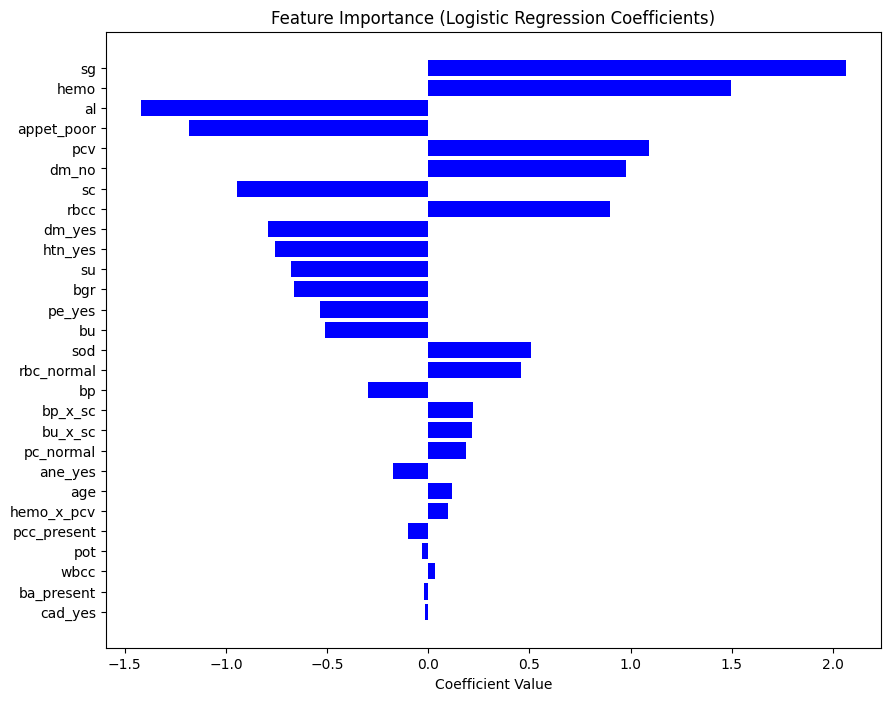

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Get the coefficients from the logistic regression model
coefficients = model.coef_.ravel()

# Create a DataFrame to visualize the feature importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': coefficients
})

# Sort by absolute value of the coefficients
importance_df['Abs_Importance'] = np.abs(importance_df['Importance'])
importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.gca().invert_yaxis()
plt.show()


#### **4.1.5) Partial Dependence Plots (PDPs):**
**Purpose:** 
  - To visualize the relationship between a feature and the predicted outcome.
    
**Why It's Important:**
  - Useful for showing how specific features influence the prediction, especially in non-linear models.

**Output:**
  - The model correctly identifies that serum creatinine has the most significant influence on predicting CKD, followed by blood urea and blood pressure. This is consistent with medical understanding and demonstrates that the model is using these features in a medically meaningful way. <br><br>
  - While each plot shows the effect of one feature independently, these relationships suggest that high levels of serum creatinine and blood urea in combination are strong indicators of CKD. The gradual influence of blood pressure suggests that it may work in conjunction with other factors to influence CKD risk.

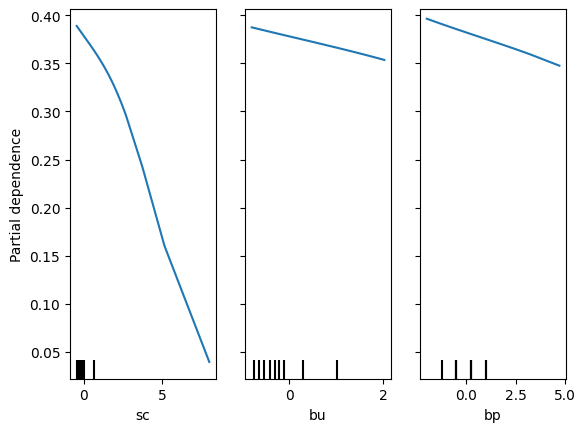

In [25]:
# Define the features for which you want to plot the partial dependence
features = ['sc', 'bu', 'bp']

# Create the partial dependence plot
PartialDependenceDisplay.from_estimator(model, X_train, features)
plt.show()


### **5) Model Interpretation:**

- The model has shown exceptional performance across various metrics, including accuracy, precision, recall, F1-score, and ROC-AUC, indicating a strong capability in distinguishing between chronic kidney disease (CKD) and non-CKD cases.

#### ***5.1) Feature Importance:***

- The feature importance chart derived from the logistic regression coefficients highlights which features have the most significant impact on the model's predictions.
- Features like specific gravity (sg), hemoglobin (hemo), albumin (al), and appetite (appet_poor) emerged as key drivers of the model's decisions.
-  These insights are crucial for understanding which factors are most influential in predicting CKD, providing both clinical relevance and interpretability.<br>
#### ***5.2) Partial Dependence Plots:***
- The partial dependence plots for features such as serum creatinine (sc), blood urea (bu), and blood pressure (bp) offer a deeper understanding of how these individual features influence the predicted probability of CKD.
- These plots show the marginal effect of a feature on the prediction, helping to visualize the relationship between a feature and the model's output while keeping other features constant.<br>
#### ***5.3) Model Performance:***
- The confusion matrix, ROC curve, and precision-recall curve all affirm the model's ability to perform well on the test set. With high precision and recall, the model not only identifies CKD cases accurately but also minimizes the number of false positives and negatives.<br>
#### ***5.4) Generalization and Overfitting:***

- The K-fold cross-validation results provide robust evidence that the model is not overfitting, as it maintains high performance across multiple subsets of the data. This process ensures that the model's performance is consistent and generalizes well to unseen data.
#### ***5.5) Potential Next Steps:***
- While the model performs well, it could be valuable to explore its robustness further by testing on external datasets or using additional validation techniques.
- Additionally, continuing to refine the model by exploring interaction terms or incorporating more domain-specific knowledge could further enhance its accuracy and applicability in clinical settings.

### **6) Deploy Model:**

In [28]:
import joblib

# Save the trained model
joblib.dump(model, 'kidney_disease_model.pkl')

['kidney_disease_model.pkl']